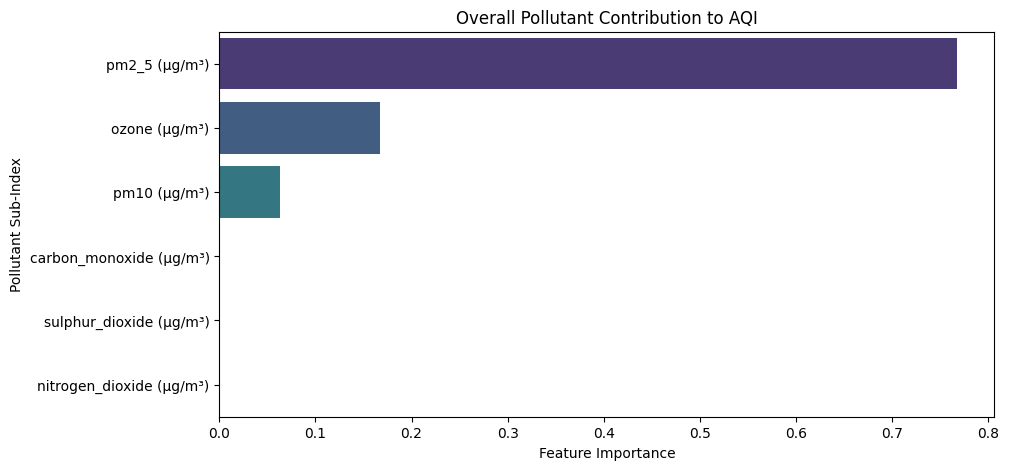

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the dataset (daily or hourly, depending on analysis scope)
df = pd.read_csv("..//data/featureddata/featured_daily.csv")  # Replace with 'featured_hourly.csv' for hourly trends

# Define features (pollutant sub-indices) and target (AQI)
# Define Features (Use Raw Pollutant Concentrations)
X = df[["pm2_5 (μg/m³)", "pm10 (μg/m³)", 
        "carbon_monoxide (μg/m³)", "ozone (μg/m³)", 
        "sulphur_dioxide (μg/m³)", "nitrogen_dioxide (μg/m³)"]]
# Define Target
y = df["AQI"]  # Only for training feature importance model, not for AQI prediction

# Split dataset (to prevent overfitting while assessing feature importance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model for Feature Importance Analysis
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract Feature Importance
feature_importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, hue="Feature", palette="viridis", legend=False)
plt.xlabel("Feature Importance")
plt.ylabel("Pollutant Sub-Index")
plt.title("Overall Pollutant Contribution to AQI")
plt.show()



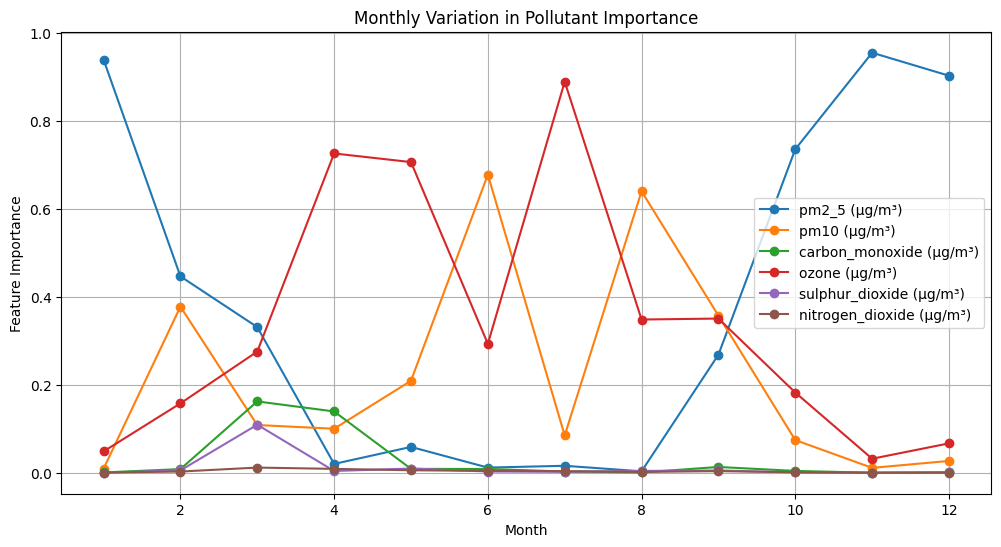

In [2]:
# Temporal Feature Importance Analysis
monthly_importance = []
months_available = sorted(df["month"].unique())

for month in months_available:
    df_month = df[df["month"] == month]
    if len(df_month) >= 30:  # Ensure enough data points per month
        X_month = df_month[["pm2_5 (μg/m³)", "pm10 (μg/m³)", 
        "carbon_monoxide (μg/m³)", "ozone (μg/m³)", 
        "sulphur_dioxide (μg/m³)", "nitrogen_dioxide (μg/m³)"]]

        y_month = df_month["AQI"]
        rf_month = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_month.fit(X_month, y_month)
        monthly_importance.append(rf_month.feature_importances_)
    else:
        monthly_importance.append([np.nan] * len(feature_names))  # Placeholder for missing months

monthly_importance = np.array(monthly_importance).T

# Plot Temporal Feature Importance Trends
plt.figure(figsize=(12, 6))
for i, feature in enumerate(feature_names):
    plt.plot(months_available, monthly_importance[i], label=feature, marker='o')
plt.xlabel("Month")
plt.ylabel("Feature Importance")
plt.title("Monthly Variation in Pollutant Importance")
plt.legend()
plt.grid(True)
plt.show()


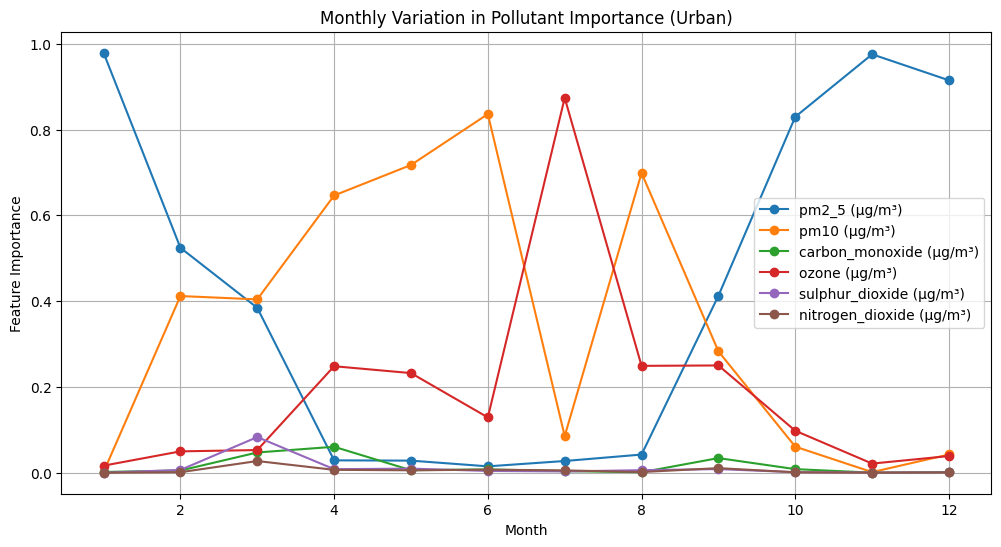

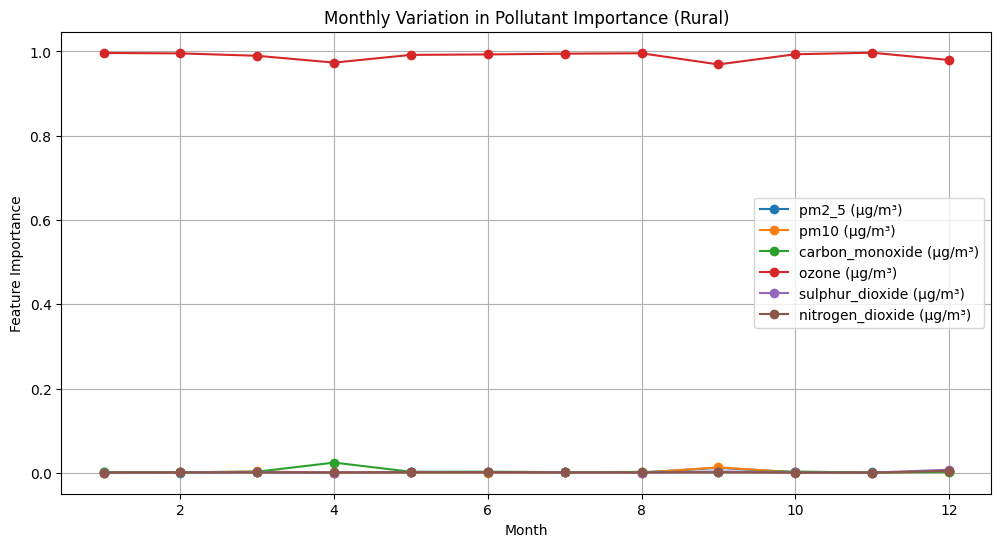

In [5]:
# Spatio-Temporal Analysis (Urban vs Rural & Location-Based)
if "Location" in df.columns and "Urban/Rural" in df.columns:
    locations = df["Location"].unique()
    urban_rural_categories = df["Urban/Rural"].unique()
    
    for category in urban_rural_categories:
        df_category = df[df["Urban/Rural"] == category]
        feature_importance_urban_rural = []
        
        for month in months_available:
            df_month = df_category[df_category["month"] == month]
            if len(df_month) >= 30:
                X_month = df_month[["pm2_5 (μg/m³)", "pm10 (μg/m³)", 
        "carbon_monoxide (μg/m³)", "ozone (μg/m³)", 
        "sulphur_dioxide (μg/m³)", "nitrogen_dioxide (μg/m³)"]]
                y_month = df_month["AQI"]
                rf_month = RandomForestRegressor(n_estimators=100, random_state=42)
                rf_month.fit(X_month, y_month)
                feature_importance_urban_rural.append(rf_month.feature_importances_)
            else:
                feature_importance_urban_rural.append([np.nan] * len(feature_names))
        
        feature_importance_urban_rural = np.array(feature_importance_urban_rural).T
        
        plt.figure(figsize=(12, 6))
        for i, feature in enumerate(feature_names):
            plt.plot(months_available, feature_importance_urban_rural[i], label=feature, marker='o')
        plt.xlabel("Month")
        plt.ylabel("Feature Importance")
        plt.title(f"Monthly Variation in Pollutant Importance ({category})")
        plt.legend()
        plt.grid(True)
        plt.show()


/tmp/ipykernel_24752/2416106570.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='year', y='AQI', hue='Urban/Rural', ci=None)


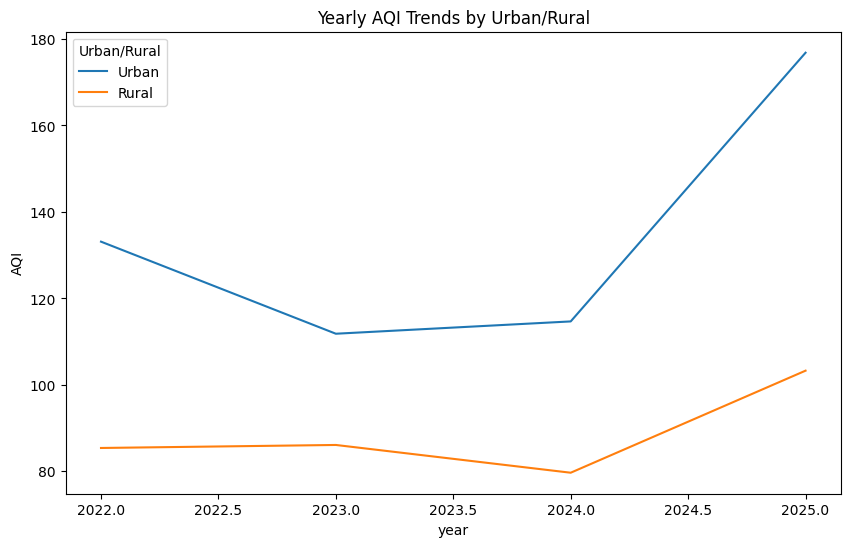

/tmp/ipykernel_24752/2416106570.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='month', y='AQI', hue='Urban/Rural', ci=None)


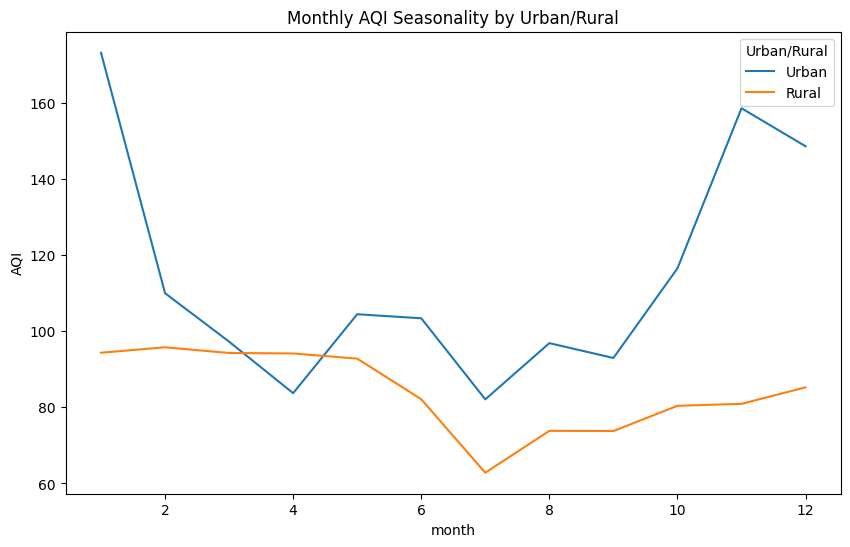

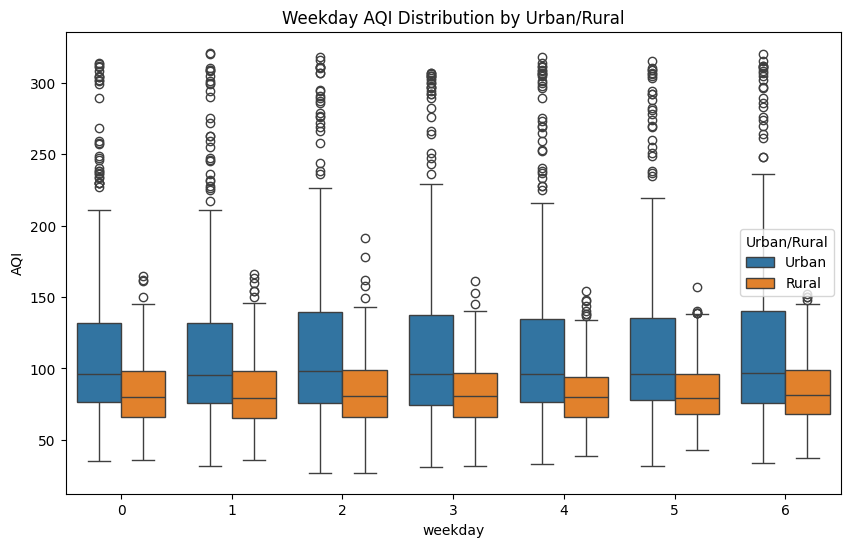

Lag Feature Correlation:
            AQI_lag_1  AQI_lag_7  AQI_lag_14  AQI_lag_30       AQI
AQI_lag_1    1.000000   0.644378    0.573554    0.496870  0.883621
AQI_lag_7    0.644378   1.000000    0.637210    0.552159  0.632676
AQI_lag_14   0.573554   0.637210    1.000000    0.559494  0.570280
AQI_lag_30   0.496870   0.552159    0.559494    1.000000  0.491491
AQI          0.883621   0.632676    0.570280    0.491491  1.000000


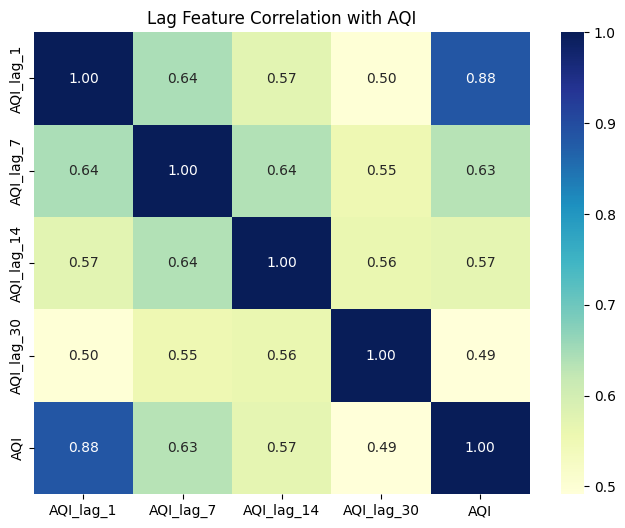

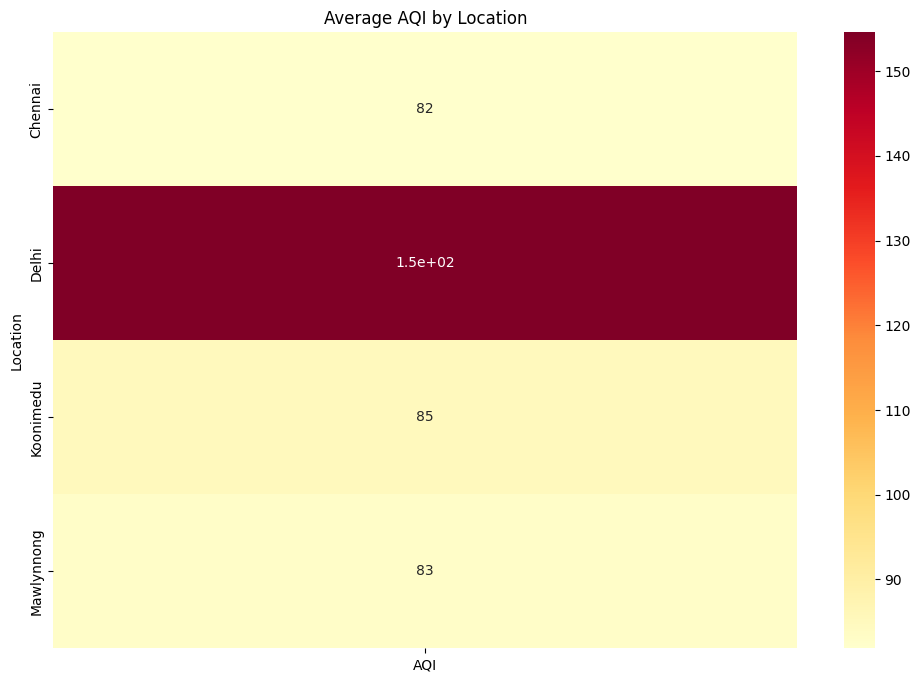

Cluster Centers:
[[  37.67037145   22.42212389  266.55188582    7.60567489    7.76123578
    82.5389587 ]
 [ 153.96606753  102.37780274 1569.82305628   65.92886522   54.84562771
    69.23623521]
 [  98.09560133   57.95797733  814.35015036   40.10577833   32.53243615
    82.15112481]]


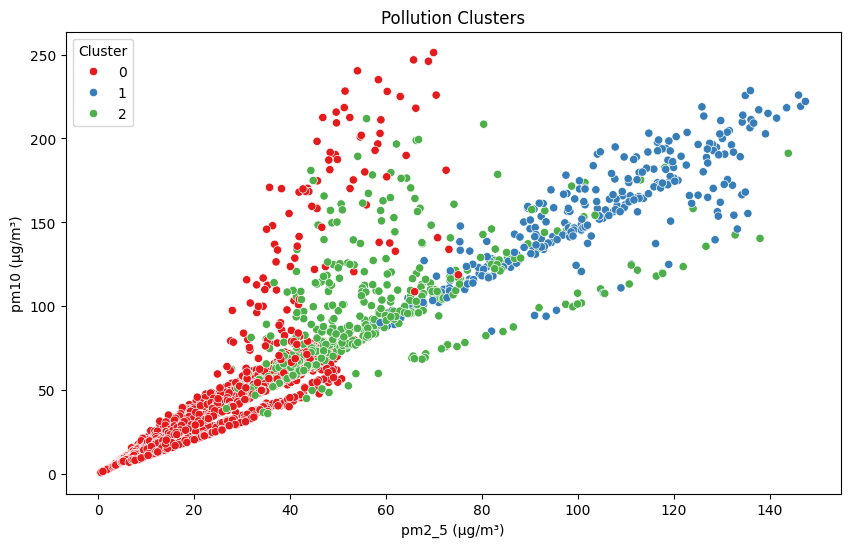

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import geopandas as gpd

# Load dataset
file_path = '../data/featureddata/featured_daily.csv'  # Adjust path if needed
df = pd.read_csv(file_path)

# Ensure date column is datetime type
df['date'] = pd.to_datetime(df['date'])


### 5. Temporal Trends Analysis
# Extract time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

# Yearly Trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='AQI', hue='Urban/Rural', ci=None)
plt.title('Yearly AQI Trends by Urban/Rural')
plt.savefig('../plots/yearly_trends.png')
plt.show()

# Monthly Seasonality
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month', y='AQI', hue='Urban/Rural', ci=None)
plt.title('Monthly AQI Seasonality by Urban/Rural')
plt.savefig('../plots/monthly_trends.png')
plt.show()

# Weekday Effect
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='weekday', y='AQI', hue='Urban/Rural')
plt.title('Weekday AQI Distribution by Urban/Rural')
plt.savefig('../plots/weekday_effect.png')
plt.show()

# Lag Analysis
lag_features = ['AQI_lag_1', 'AQI_lag_7', 'AQI_lag_14', 'AQI_lag_30']
lag_corr = df[lag_features + ['AQI']].corr()
print("Lag Feature Correlation:")
print(lag_corr)

plt.figure(figsize=(8, 6))
sns.heatmap(lag_corr, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Lag Feature Correlation with AQI')
plt.savefig('../plots/lag_correlation.png')
plt.show()

### 6. Spatial Distribution Analysis
# Heatmap of AQI by Location
pivot_table = df.pivot_table(index='Location', values='AQI', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True)
plt.title('Average AQI by Location')
plt.savefig('../plots/spatial_heatmap.png')
plt.show()

### 7. Cluster Analysis
cluster_data = df[pollutants]

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(cluster_data)

print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pm2_5 (μg/m³)', y='pm10 (μg/m³)', hue='Cluster', palette='Set1')
plt.title('Pollution Clusters')
plt.savefig('../plots/pollution_clusters.png')
plt.show()
